Установите количество пропущенных значений колонки age: 199
Вычислите долю выживших: 0.382262996941896
Колонки, которые будут удалены: ['ticket', 'cabin', 'home.dest']
Вычислите выборочное среднее колонки fam_size: 0.8664627930682977
Вычислите число предикторов полученного набора данных: 7
вероятность выжить если пассажир -- представитель следующей категории: female and pclass:3: 0.5030674846625767


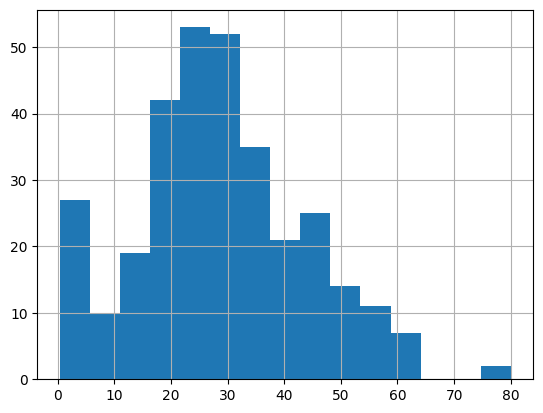

f1_score =  0.5471698113207547
f1_score =  0.4297520661157025
Число уникальных обращений: 14
Вычислите долю строк со значением Master относительно числа всех мужчин: 0.07232704402515723
Вычислите средний возраст категории Miss: 22.005765408805033
f1_score =  0.43902439024390244
f1_score =  0.6575342465753424


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

# 1. Подготовка и первичный анализ данных

df = pd.read_csv('titanic_train.csv')

print('Установите количество пропущенных значений колонки age:', df['age'].isna().sum())
print('Вычислите долю выживших:', df['survived'].sum() / df['survived'].count())

cols_to_delete = ['ticket']
for col in df.columns:
    if (df[col].isna().sum() / len(df) > 1/3): cols_to_delete.append(col)
print('Колонки, которые будут удалены:', cols_to_delete)
df.drop(cols_to_delete, axis=1, inplace=True)

df['fam_size'] = df['sibsp'] + df['parch']
df.drop(['sibsp', 'parch'], axis=1, inplace=True)
print('Вычислите выборочное среднее колонки fam_size:', df['fam_size'].mean())

print('Вычислите число предикторов полученного набора данных:', len(df.columns) - 1)

print('вероятность выжить если пассажир -- представитель следующей категории: female and pclass:3:', df[(df['sex'] == 'female') & (df['pclass'] == 3)]['survived'].sum() / len(df[(df['sex'] == 'female') & (df['pclass'] == 3)]))

df[df['survived'] == 1]['age'].hist(bins=15)
plt.show()

# 2. Модель на основе числовых признаков
random_state = 11
test_size = 0.2
max_iter = 1000

df_only_numeric = df.select_dtypes(include=np.number).dropna()
x_train, x_test, y_train, y_test = train_test_split(df_only_numeric.drop('survived', axis=1), df_only_numeric['survived'], random_state=random_state, test_size=test_size, stratify=df_only_numeric['survived'])
lre = LogisticRegression(random_state=random_state, max_iter=max_iter)
lre.fit(x_train, y_train)
y_pred = lre.predict(x_test)
print('f1_score = ', f1_score(y_test, y_pred))


df_only_numeric = df.select_dtypes(include=np.number)

for col in df_only_numeric.columns:
    df_only_numeric[col].fillna(df_only_numeric[col].mean(), inplace=True)
x_train, x_test, y_train, y_test = train_test_split(df_only_numeric.drop('survived', axis=1), df_only_numeric['survived'], random_state=random_state, test_size=test_size, stratify=df_only_numeric['survived'])
lre = LogisticRegression(random_state=random_state, max_iter=max_iter)
lre.fit(x_train, y_train)
y_pred = lre.predict(x_test)
print('f1_score = ', f1_score(y_test, y_pred))

df_only_numeric = df.select_dtypes(include=np.number)
df_only_numeric['honorific'] = df['name'].apply(lambda x: re.search(r' (\S+?)\. ', x).group(1))
print('Число уникальных обращений:', len(df_only_numeric['honorific'].unique()))
print('Вычислите долю строк со значением Master относительно числа всех мужчин:', len(df_only_numeric[(df_only_numeric['honorific'] == 'Master') & (df['sex'] == 'male')]) / len(df_only_numeric[df['sex'] == 'male']))

replacements = {
    'Mr': ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'],
    'Mrs': ['Dona', 'Countess'],
    'Miss': ['Mlle', 'Ms']
}

def replace_honorific(x):
    for k in replacements:
        if (x in replacements[k]): return k
    
    return x

df_only_numeric['honorific'] = df_only_numeric['honorific'].apply(replace_honorific)
print('Вычислите средний возраст категории Miss:', df_only_numeric.groupby('honorific')['age'].mean()['Miss'])

df_only_numeric['age'] = df_only_numeric.groupby('honorific')['age'].transform(lambda x: x.fillna(x.mean()))
df_only_numeric.drop('honorific', axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(df_only_numeric.drop('survived', axis=1), df_only_numeric['survived'], random_state=random_state, test_size=test_size, stratify=df_only_numeric['survived'])
lre = LogisticRegression(random_state=random_state, max_iter=max_iter)
lre.fit(x_train, y_train)
y_pred = lre.predict(x_test)
print('f1_score = ', f1_score(y_test, y_pred))

# 3. Модель с использованим категориальных признаков

df['age'] = df_only_numeric['age']
df.drop('name', axis=1, inplace=True)

dummies = pd.get_dummies(df.select_dtypes(exclude=np.number), prefix=df.select_dtypes(exclude=np.number).columns, drop_first=True)
df[dummies.columns] = dummies
df.drop(df.select_dtypes(exclude=np.number).columns, axis=1, inplace=True)

x_train, x_test, y_train, y_test = train_test_split(df.drop('survived', axis=1), df['survived'], random_state=random_state, test_size=test_size, stratify=df['survived'])
lre = LogisticRegression(random_state=random_state, max_iter=max_iter)
lre.fit(x_train, y_train)
y_pred = lre.predict(x_test)
print('f1_score = ', f1_score(y_test, y_pred))